In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from fastdot import *
from efficientnet_pytorch.utils import round_filters, round_repeats, GlobalParams

In [3]:
def add_input_output(c, inp_tooltip='', outp_tooltip=''):
    inp = Node('input', tooltip=inp_tooltip)
    outp = Node('output', tooltip=outp_tooltip)
    g = graph_items(inp, c, outp)
    g.add_items(inp.connect(c.get_nodes()[0]), c.get_nodes()[-1].connect(outp))    
    return g

In [4]:
global_params = GlobalParams(
    # specific to effnet b3
    width_coefficient=1.2,
    depth_coefficient=1.4,
    image_size=300,
    dropout_rate=0.3,

    # same for all effnets
    num_classes=1000,
    batch_norm_momentum=0.99,
    batch_norm_epsilon=1e-3,
    drop_connect_rate=0.2,
    depth_divisor=8,
    min_depth=None,
)

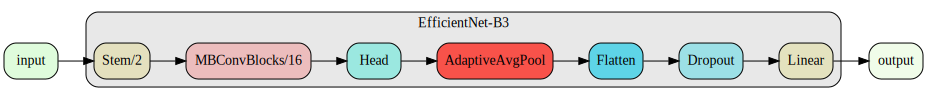

In [5]:
eb3 = seq_cluster(['Stem/2', 'MBConvBlocks/16', 'Head', 'AdaptiveAvgPool', 'Flatten', 'Dropout', 'Linear'], 'EfficientNet-B3')
eb3.get_nodes()[-1].set_tooltip(f'channel={round_filters(1280, global_params)}')
eb3.get_nodes()[-2].set_tooltip(f'probability={global_params.dropout_rate}')
add_input_output(eb3, f'channel=3, resolution={global_params.image_size}', 'classes=1000')

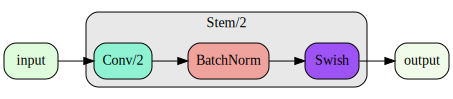

In [6]:
stem = seq_cluster(['Conv/2', 'BatchNorm', 'Swish'], 'Stem/2')
stem.get_nodes()[0].set_tooltip(f'channel={round_filters(32, global_params)}, stride=2')

add_input_output(stem, f'channel=3, resolution={global_params.image_size}', f'channel={round_filters(32, global_params)}, resolution={global_params.image_size // 2}')

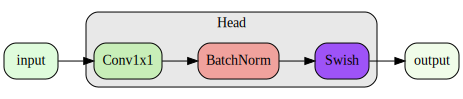

In [7]:
head = seq_cluster(['Conv1x1', 'BatchNorm', 'Swish'], 'Head')
head.get_nodes()[0].set_tooltip(f'channel={round_filters(1280, global_params)}')

add_input_output(head, f'channel={round_filters(320, global_params)}, resolution={global_params.image_size // 32}', f'channel={round_filters(1280, global_params)}, resolution={global_params.image_size // 32}')

In [8]:
blocks_args = [
    'r1_k3_s11_e1_i32_o16_se0.25',
    'r2_k3_s22_e6_i16_o24_se0.25',
    'r2_k5_s22_e6_i24_o40_se0.25',
    'r3_k3_s22_e6_i40_o80_se0.25',
    'r3_k5_s11_e6_i80_o112_se0.25',
    'r4_k5_s22_e6_i112_o192_se0.25',
    'r1_k3_s11_e6_i192_o320_se0.25',
]

In [9]:
repeats = [1, 2, 2, 3, 3, 4, 1]

for i in range(7):
    repeats[i] = round_repeats(repeats[i], global_params)

repeats

[2, 3, 3, 5, 5, 6, 2]

In [12]:
dc_rate = []
for i in range(7):
    drop_connect_rate = global_params.drop_connect_rate
    drop_connect_rate *= float(i) / 7
    dc_rate.append(drop_connect_rate)

dc_rate

[0.0,
 0.02857142857142857,
 0.05714285714285714,
 0.08571428571428572,
 0.11428571428571428,
 0.14285714285714288,
 0.17142857142857143]

In [13]:
print(round_filters(32, global_params))

output_channels = [16, 24, 40, 80, 112, 192, 320]

for i in range(7):
    output_channels[i]=round_filters(output_channels[i], global_params)
    
output_channels

40


[24, 32, 48, 96, 136, 232, 384]

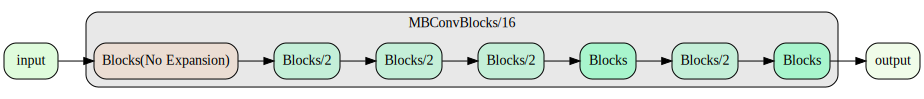

In [14]:
mbbs = seq_cluster(['Blocks(No Expansion)', 'Blocks/2', 'Blocks/2', 'Blocks/2', 'Blocks', 'Blocks/2', 'Blocks'], 'MBConvBlocks/16')

for i in range(7):
    mbbs.get_nodes()[i].set_tooltip(f'repeats={repeats[i]}, dropconnect={dc_rate[i]}, channels={output_channels[i]}')

add_input_output(mbbs, f'channel={round_filters(32, global_params)}, resolution={global_params.image_size//2}', f'channel={round_filters(320, global_params)}, resolution={global_params.image_size//32}')

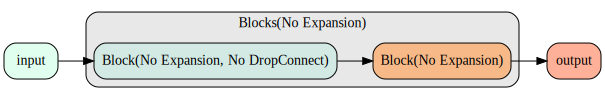

In [13]:
blocks = seq_cluster(['Block(No Expansion, No DropConnect)', 'Block(No Expansion)'], 'Blocks(No Expansion)')

add_input_output(blocks, f'channel={round_filters(32, global_params)}, resolution={global_params.image_size//2}', f'channel={output_channels[0]}, resolution={global_params.image_size//2}')

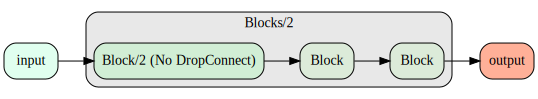

In [14]:
blocks2 = seq_cluster(['Block/2 (No DropConnect)', 'Block', 'Block'], 'Blocks/2')

add_input_output(blocks2, f'channel={output_channels[0]}, resolution={global_params.image_size//2}', f'channel={output_channels[1]}, resolution={global_params.image_size//4}')

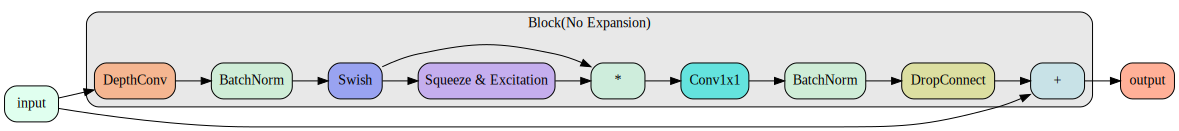

In [15]:
block = seq_cluster(['DepthConv', 'BatchNorm', 'Swish', 'Squeeze & Excitation', '*', 'Conv1x1', 'BatchNorm', 'DropConnect', '+'], 'Block(No Expansion)')
nodes = block.get_nodes()
block.add_items(nodes[2].connect(nodes[4]))
g = add_input_output(block, '', '')
g.add_items(g.get_nodes()[0].connect(nodes[-1]))
g

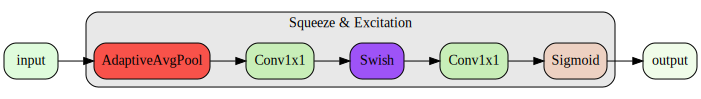

In [15]:
rb = seq_cluster(['AdaptiveAvgPool', 'Conv1x1', 'Swish', 'Conv1x1', 'Sigmoid'], 'Squeeze & Excitation')
add_input_output(rb, '', '')

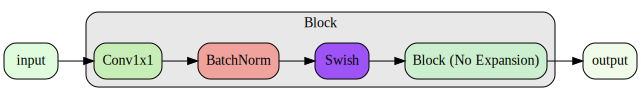

In [16]:
block = seq_cluster(['Conv1x1', 'BatchNorm', 'Swish', 'Block (No Expansion)'], 'Block')
add_input_output(block, '', '')